In [38]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_curve, auc
# from progress.bar import Bar
%matplotlib inline

### Import Dataset

In [39]:
columns1=['age','workclass','fnlwgt','education','education_num','marital_status','occupation','relationship','race','sex','capital_gain','capital_loss','hours_per_week','native_country','sal']

In [40]:
raw_df=pd.read_csv('adult.data',names=columns1)

In [41]:
raw_df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,sal
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [42]:
raw_df['native_country'] = raw_df['native_country'].str.strip()

In [43]:
#slicing dataset for native_country is united states
usa_df=raw_df[raw_df['native_country']=='United-States']

In [44]:
usa_df['education'].value_counts()

 HS-grad         9702
 Some-college    6740
 Bachelors       4766
 Masters         1527
 Assoc-voc       1289
 11th            1067
 Assoc-acdm       982
 10th             848
 Prof-school      502
 7th-8th          499
 9th              395
 12th             365
 Doctorate        328
 5th-6th           97
 1st-4th           46
 Preschool         17
Name: education, dtype: int64

In [45]:
df=usa_df.copy()

In [46]:
df.drop('native_country',axis=1,inplace=True)#There is no need for native_country as this whole dataset belons to USA

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29170 entries, 0 to 32560
Data columns (total 14 columns):
age               29170 non-null int64
workclass         29170 non-null object
fnlwgt            29170 non-null int64
education         29170 non-null object
education_num     29170 non-null int64
marital_status    29170 non-null object
occupation        29170 non-null object
relationship      29170 non-null object
race              29170 non-null object
sex               29170 non-null object
capital_gain      29170 non-null int64
capital_loss      29170 non-null int64
hours_per_week    29170 non-null int64
sal               29170 non-null object
dtypes: int64(6), object(8)
memory usage: 3.3+ MB


In [48]:
df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,sal
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,<=50K


### EDA

In [49]:
#COUNT for capital_gain as mostly of it is zero
(df['capital_gain']==0).value_counts()

True     26699
False     2471
Name: capital_gain, dtype: int64

In [50]:
(df['capital_loss']==0).value_counts()#for capital_loss column

True     27791
False     1379
Name: capital_loss, dtype: int64

#### We can see 90 % of value is zero for both variables so we can drop it. In addition, we can also drop finalwgt and education_num as finalwgt depends on demographics and education_num is irrelevant as we already have education variable in dataset.

In [51]:
df.drop(['capital_gain','capital_loss','education_num','fnlwgt'],axis=1,inplace=True)

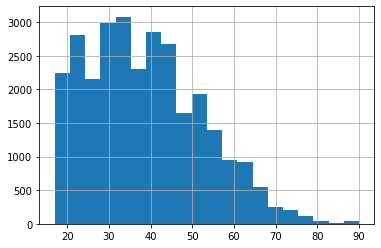

In [52]:
df['age'].hist(bins=20)

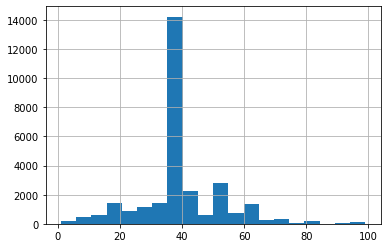

In [53]:
df['hours_per_week'].hist(bins=20)


In [17]:
# plt.figure(figsize=(20,10))
# plt.title('salary vs education ')
# sns.barplot(x='education',y='sal',data=df,hue='sex',palette='seismic')

In [18]:
# plt.figure(figsize=(25,10))
# sns.barplot(x='occupation',y='sal',data=df,hue='sex',palette='coolwarm')

In [19]:
# plt.figure(figsize=(20,10))
# sns.barplot(x='marital_status',y='sal',data=df,hue='sex',palette="seismic")

#### Encoding categorical variable

In [54]:
cat_feats=['workclass','education','marital_status','occupation','relationship','race','sex','sal']
df = pd.get_dummies(df,columns=cat_feats,drop_first=True)



#### Feature Engineering and Selection with PCA

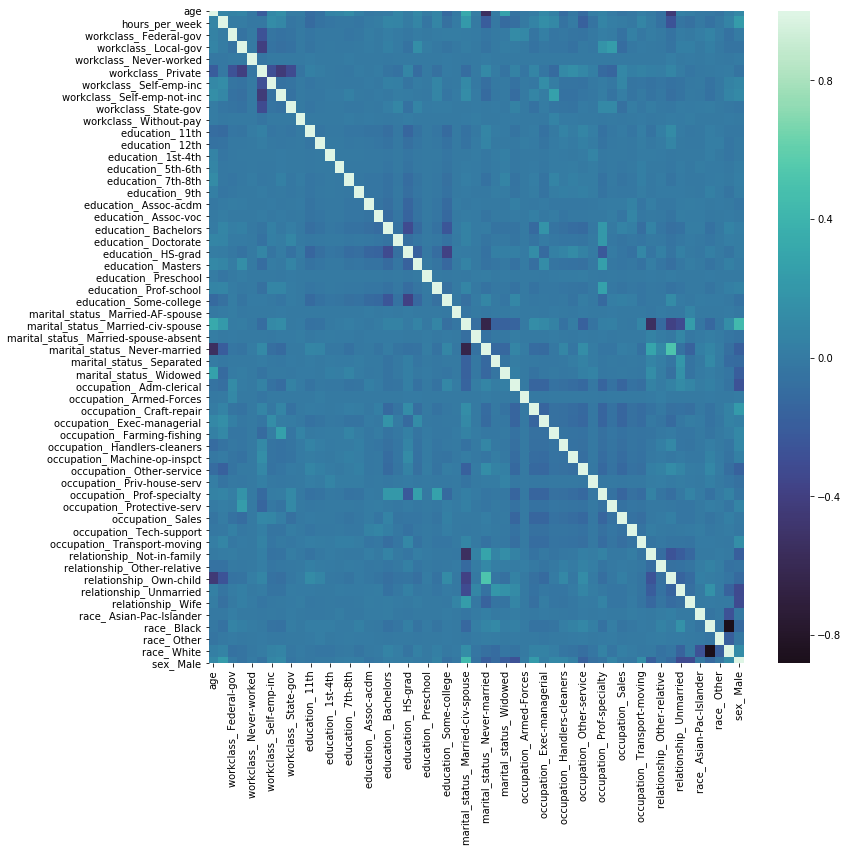

In [57]:
plt.figure(figsize=(12,12))
sns.heatmap(X.corr(), center=0,cmap='mako')

#### Standardize the Variables

In [61]:
df.drop(['age','hours_per_week'],axis=1)

,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 11th,education_ 12th,...,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Male,sal_ >50K
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
32557,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
32558,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
32559,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0


In [80]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

num_cols=['age','hours_per_week']
df_num = pd.DataFrame(scaler.fit_transform(df[num_cols]),columns= num_cols)
df=pd.merge(df_num,df)

# X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)

# X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)


In [81]:

df.head()

,age,hours_per_week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,...,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Male,sal_ >50K
0,0.826715,-2.210500,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
1,0.972465,0.366614,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,1
2,0.972465,0.366614,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
3,0.972465,0.366614,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
4,0.972465,0.366614,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,1


In [82]:
#partitioning predictor and target variable
y=df['sal_ >50K']
X=df.drop(['sal_ >50K'],axis=1)



In [83]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [84]:
from sklearn.decomposition import PCA
pca = PCA()
X_train = pca.fit_transform(X_train)
print(pca.explained_variance_ratio_)

[3.55291258e-01 8.93878677e-02 6.38798610e-02 5.01633982e-02
 4.34310757e-02 4.04765681e-02 3.34405060e-02 2.94254513e-02
 2.79444854e-02 2.58381871e-02 2.44891574e-02 1.94663188e-02
 1.78953079e-02 1.65135430e-02 1.42697380e-02 1.38256097e-02
 1.26282228e-02 1.04655912e-02 9.54249763e-03 9.34169623e-03
 7.88383292e-03 7.56345527e-03 7.13673097e-03 6.33249256e-03
 6.17762823e-03 6.06865819e-03 5.32710773e-03 5.00471109e-03
 4.22131923e-03 4.08172125e-03 3.88407314e-03 3.37425589e-03
 3.27860026e-03 3.07006007e-03 2.94769405e-03 2.65627907e-03
 2.07075051e-03 1.91001571e-03 1.67885124e-03 1.58771272e-03
 1.47237137e-03 1.20616755e-03 1.11019260e-03 5.23745233e-04
 4.44759058e-04 3.11508839e-04 2.68616396e-04 2.39554260e-04
 1.44522739e-04 8.72082804e-05 8.37404980e-05 7.14451894e-05
 4.08214760e-05 2.30550011e-05 7.00688459e-32]


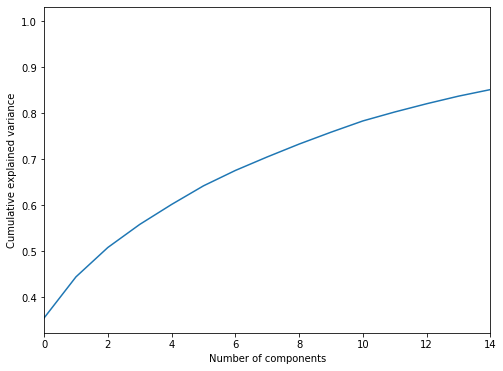

In [85]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,14,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

#### Create Baseline model

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_curve, auc

In [87]:
# Construct some pipelines
pipe_lr = Pipeline([('pca', PCA(n_components=14, random_state=123)),
         ('clf', LogisticRegression(random_state=123))])

# Fit the pipelines
pipe_lr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=14,
                     random_state=123, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=123,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [88]:
predict = pipe_lr.predict(X_train)

In [89]:

# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train,predict)
roc_auc = auc(false_positive_rate,true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))


AUC is :0.77


#### Create a pipeline consisting of a linear SVM, a simple Decision Tree and a simple Random Forest Classifier

In [ ]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc

## KEEP IT FOR NOW
# Construct some pipelines
pipe_svm = Pipeline([('pca', PCA(n_components=14)),
        ('clf', svm.SVC(random_state=123))])
        
pipe_tree = Pipeline([('pca', PCA(n_components=14)),
        ('clf', tree.DecisionTreeClassifier(random_state=123))])

pipe_rf = Pipeline([('pca', PCA(n_components=14)),
        ('clf', RandomForestClassifier(random_state=123))])

# List of pipelines, List of pipeline names
pipelines = [pipe_svm, pipe_tree, pipe_rf]
pipeline_names = ['Support Vector Machine','Decision Tree','Random Forest']

# Loop to fit each of the three pipelines
for pipe in pipelines:
    print(pipe)
    pipe.fit(X_train, y_train)
    
# Loop to fit each of the three pipelines
for pipe in pipelines:
    print(pipe)
    pipe.predict(X_train)

# # Compare AUC
# for index, val in enumerate(pipelines):
#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train,pipe.predict)
#     roc_auc = auc(false_positive_rate,true_positive_rate)
#     print('\nAUC is :{0}'.format(round(roc_auc, 2)))